### Introduction

The problem we aim to solve involves determining the discount curve for the UK government bond (gilt) market on 4 September 1996. The market data is presented in the table below:

| Bond  | Coupon (%) | Next Coupon | Maturity Date | Price |
|-------|------------|-------------|---------------|-----------------------|
| Bond 1 | 10.00 | 15/11/96 | 15/11/96 | 103.82 |
| Bond 2 | 9.75  | 19/01/97 | 19/01/98 | 106.04 |
| Bond 3 | 12.25 | 26/09/96 | 26/03/99 | 118.44 |
| Bond 4 | 9.00  | 03/03/97 | 03/03/00 | 106.28 |
| Bond 5 | 7.00  | 06/11/96 | 06/11/01 | 101.15 |
| Bond 6 | 9.75  | 27/02/97 | 27/08/02 | 111.06 |
| Bond 7 | 8.50  | 07/12/96 | 07/12/05 | 106.24 |
| Bond 8 | 7.75  | 08/03/97 | 08/09/06 | 98.49 |
| Bond 9 | 9.00  | 13/10/96 | 13/10/08 | 110.87 |

Our objective is to construct a discount curve that accurately reproduces these market prices using the pseudoinverse method.

### Mathematical Formulation

The pseudoinverse method offers an alternative approach for estimating the term structure of interest rates. Unlike the traditional bootstrapping method, which relies on synthetic market instruments to make the cash flow matrix invertible, the pseudoinverse method minimizes the Euclidean norm of the weighted increments vector, producing a smooth discount curve.

We are given $n$ market instrument prices $(p_1, \ldots, p_n)^T$ at the spot date $t_0$. There are $N$ cash flow dates $t_0 < t_1 < \cdots < t_N$ and a corresponding $n \times N$ cash flow matrix $(c_{ij})$.

The goal is to find a discount curve $(P(t_0, t_1), \ldots, P(t_0, t_N))^T$ that matches the observed market prices:

$$
C d = p
$$

Instead of estimating the discount function $d$ directly, we estimate the weighted increments vector $\Delta$ defined as:

$$
\Delta = 
\begin{bmatrix}
\frac{P(t_0,t_1)-1}{\sqrt{\delta(t_1,t_0)}} \\
\frac{P(t_0,t_2)-P(t_0,t_1)}{\sqrt{\delta(t_2,t_1)}} \\
\vdots \\
\frac{P(t_0,t_N)-P(t_0,t_{N-1})}{\sqrt{\delta(t_N,t_{N-1})}}
\end{bmatrix}
$$

The weighted increments vector can be expressed as:

$$
\Delta = W \left( M d - e_1 \right)
$$

where $e_1 = (1, 0, \ldots, 0)^T$, and the matrices $W$ and $M$ are defined as:

Matrix $W$:

$$
W = 
\begin{pmatrix}
\frac{1}{\sqrt{\delta(t_1, t_0)}} & 0 & 0 & \cdots & 0 \\
0 & \frac{1}{\sqrt{\delta(t_2, t_1)}} & 0 & \cdots & 0 \\
0 & 0 & \frac{1}{\sqrt{\delta(t_3, t_2)}} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \frac{1}{\sqrt{\delta(t_n, t_{n-1})}}
\end{pmatrix}
$$

Matrix $M$:

$$
M = 
\begin{pmatrix}
1 & 0 & 0 & 0 & \cdots & 0 \\
-1 & 1 & 0 & 0 & \cdots & 0 \\
0 & -1 & 1 & 0 & \cdots & 0 \\
0 & 0 & -1 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0 & -1 & 1
\end{pmatrix}
$$

#### Minimization Problem and Gradient

We start with the equation:

$$
\Delta = W \left( M d - e_1 \right) \implies d = M^{-1} \left( W^{-1} \Delta + e_1 \right)
$$

Substitute this expression for $d$ into $C d = p$:

$$
C \left( M^{-1} \left( W^{-1} \Delta + e_1 \right) \right) = p
$$

$$
C M^{-1} W^{-1} \Delta + C M^{-1} e_1 = p
$$

This is the equation to minimize the residuals:

$$
\min_{\Delta} \left\| A \Delta - \left( p - C M^{-1} e_1 \right) \right\|^2
$$

where $A = C M^{-1} W^{-1}$.

Now, to find the optimal $\Delta$, we take the gradient of the objective function:

$$
\nabla f(\Delta) = 2 A^T \left( A \Delta - \left( p - C M^{-1} e_1 \right) \right) = 0 
\implies \Delta^* = \left( A^T A \right)^{-1} A^T \left( p - C M^{-1} e_1 \right)
$$


### Implementation steps

 ##### Step 1: Create vector Price
The vector $p = (p_1, p_2, ..., p_n)^T$ contains the market prices of the bonds at the spot date $t_0$.

##### Step 2: Create cash flow matrix $C$
The matrix $C$ represents the cash flows of the bonds, where each row corresponds to a bond and each column corresponds to a cash flow date. If a bond does not have a cash flow at a specific date, the corresponding value is set to $0$.

##### Step 3: Create weight matrix $W$ and matrix $M$
The weight matrix $W$ is a diagonal matrix where each entry is the square root of the time difference between cash flow dates. The matrix $M$ is a tridiagonal matrix that encodes the differences between consecutive discount factors.

##### Step 4: Compute matrix $A$
The matrix $A$ is computed as:

$$ A = C M^{-1} W^{-1} $$

##### Step 5: Compute $\Delta^*$ that minimizes the Euclidean norm
To minimize the Euclidean norm, solve for the optimal $\Delta^*$:

$$ \Delta^* = (A^T A)^{-1} A^T (p - C M^{-1} e_1) $$

##### Step 6: Find discount curve
Once $\Delta^*$ is computed, the discount curve $d$ can be found by using:

$$ d = M^{-1} (W^{-1} \Delta^* + e_1) $$


### Implementation in python

##### Application setting

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
DATE_FORMAT = '%d/%m/%Y'
NOMINAL = 100
DATE_CONVENTION = "30/360"
SPOT_DATE= datetime(1996, 9, 4) 
bond_data = "bond_data_gilt.csv"

##### Read bond data

In [5]:
bond_data = pd.read_csv('bond_data_gilt.csv') 
bond_data['Next coupon'] = pd.to_datetime(bond_data['Next coupon'],format=DATE_FORMAT, errors='coerce')
bond_data['Maturity'] = pd.to_datetime(bond_data['Maturity'],format=DATE_FORMAT, errors='coerce')
bond_data['Coupon'] = bond_data['Coupon']/100 
bond_data

,Bonds,Coupon,Next coupon,Maturity,Price
0,Bond 1,0.1000,1996-11-15,1996-11-15,103.82
1,Bond 2,0.0975,1997-01-19,1998-01-19,106.04
2,Bond 3,0.1225,1996-09-26,1999-03-26,118.44
3,Bond 4,0.0900,1997-03-03,2000-03-03,106.28
4,Bond 5,0.0700,1996-11-06,2001-11-06,101.15
5,Bond 6,0.0975,1997-02-27,2002-08-27,111.06
6,Bond 7,0.0850,1996-12-07,2005-12-07,106.24
7,Bond 8,0.0775,1997-03-08,2006-09-08,98.49
8,Bond 9,0.0900,1996-10-13,2008-10-13,110.87


In [6]:
def generate_cash_flow_dates(row):
    start_date = row['Next coupon']
    end_date = row['Maturity']
    cash_flow_dates = []
    while start_date <= end_date:
        cash_flow_dates.append(start_date.date())
        start_date += relativedelta(months=6)
    return cash_flow_dates
bond_data['bond_cash_flow_date'] = bond_data.apply(generate_cash_flow_dates, axis=1)  
bond_cash_flow_date = [item for sublist in bond_data['bond_cash_flow_date'] for item in sublist]
instruments = bond_data['Bonds'].values
bond_cash_flow_date.sort()
bond_data

,Bonds,Coupon,Next coupon,Maturity,Price,bond_cash_flow_date
0,Bond 1,0.1000,1996-11-15,1996-11-15,103.82,[1996-11-15]
1,Bond 2,0.0975,1997-01-19,1998-01-19,106.04,"[1997-01-19, 1997-07-19, 1998-01-19]"
2,Bond 3,0.1225,1996-09-26,1999-03-26,118.44,"[1996-09-26, 1997-03-26, 1997-09-26, 1998-03-2..."
3,Bond 4,0.0900,1997-03-03,2000-03-03,106.28,"[1997-03-03, 1997-09-03, 1998-03-03, 1998-09-0..."
4,Bond 5,0.0700,1996-11-06,2001-11-06,101.15,"[1996-11-06, 1997-05-06, 1997-11-06, 1998-05-0..."
5,Bond 6,0.0975,1997-02-27,2002-08-27,111.06,"[1997-02-27, 1997-08-27, 1998-02-27, 1998-08-2..."
6,Bond 7,0.0850,1996-12-07,2005-12-07,106.24,"[1996-12-07, 1997-06-07, 1997-12-07, 1998-06-0..."
7,Bond 8,0.0775,1997-03-08,2006-09-08,98.49,"[1997-03-08, 1997-09-08, 1998-03-08, 1998-09-0..."
8,Bond 9,0.0900,1996-10-13,2008-10-13,110.87,"[1996-10-13, 1997-04-13, 1997-10-13, 1998-04-1..."


#### Price P

In [7]:
P = bond_data['Price']
P

0    103.82
1    106.04
2    118.44
3    106.28
4    101.15
5    111.06
6    106.24
7     98.49
8    110.87
Name: Price, dtype: float64

#### Cashflow matrix C

Here we generate the cash flow matrix, where each $c_{ij}$ represents the cash flow at time $j$ for instrument $i$. If an instrument does not have a cash flow at time $j$, its value is set to 0. The matrix is populated with coupon payments, and the last payment for each bond is adjusted to include the nominal value at maturity

In [16]:
cash_flow_matrix = np.zeros((len(instruments), len(bond_cash_flow_date)),dtype=float)
for i in range(len(instruments)):
    for j in range(len(bond_cash_flow_date)):
        current_date =  bond_cash_flow_date[j]
        if current_date in bond_data.loc[i, 'bond_cash_flow_date'] :
            cash_flow_matrix[i,j] = bond_data.loc[i, 'Coupon']*NOMINAL/2 
            if current_date == bond_data.loc[i, 'Maturity'].date() :
                 cash_flow_matrix[i,j] = cash_flow_matrix[i,j]+ NOMINAL 

cash_flow_df = pd.DataFrame(cash_flow_matrix, columns = bond_cash_flow_date)
cash_flow_df.head(4)

,1996-09-26,1996-10-13,1996-11-06,1996-11-15,1996-12-07,1997-01-19,1997-02-27,1997-03-03,1997-03-08,1997-03-26,...,2005-10-13,2005-12-07,2006-03-08,2006-04-13,2006-09-08,2006-10-13,2007-04-13,2007-10-13,2008-04-13,2008-10-13
0,0.000,0.0,0.0,105.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,0.0,0.0,0.0,0.0,4.875,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.125,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,6.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0.0,0.0,0.0,0.0,0.000,0.0,4.5,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Weight matrix W

Here we generate the weight matrix, where each entry $w_{ij}$ represents the weight between cash flow dates $i$ and $j$. The diagonal entries correspond to the square root of the time difference between consecutive cash flow dates, while the first entry takes the square root of the time difference between the spot date and the first cash flow date. This matrix is used to scale the increments in the weighted least squares method

In [9]:
def compute_diff_date(start_date, end_date, market_convention):
    if market_convention =="Actual/Actual": return  (end_date - start_date).days / 365
    if market_convention =="Actual/360": return  (end_date - start_date).days / 360
    if market_convention =="Actual/365": return  (end_date - start_date).days / 365
    return ((end_date.year - start_date.year) * 360 +(end_date.month - start_date.month) * 30 + (min(end_date.day, 30) - min(start_date.day, 30))) / 360

weight_matrix = np.zeros((len(bond_cash_flow_date), len(bond_cash_flow_date)),dtype=float)
weight_matrix[0,0] = np.sqrt(compute_diff_date(SPOT_DATE.date(),bond_cash_flow_date[0],DATE_CONVENTION)) 
for i in range(1, len(bond_cash_flow_date)):
       weight_matrix[i,i]= np.sqrt(compute_diff_date(bond_cash_flow_date[i-1],bond_cash_flow_date[i],DATE_CONVENTION))
weight_matrix  

array([[0.24720662, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21730675, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25276251, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.70710678, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.70710678]])

### M matrix

Here we generate the matrix $M$, where each entry $m_{ij}$ represents the relationship between consecutive cash flow dates. The diagonal entries are set to 1, indicating no change in the discount factor between the same date. The entries directly below the diagonal are set to -1, representing the difference in discount factors between consecutive dates. This matrix is used to model the change in the discount curve across time

In [10]:
m_matrix = np.zeros((len(bond_cash_flow_date), len(bond_cash_flow_date)),dtype=float)
for i in range(len(bond_cash_flow_date)):
    for j in range(len(bond_cash_flow_date)):
        if i==j: m_matrix[i,i]= 1
        if i-1==j: m_matrix[i,j]= -1
m_matrix  

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

### UNIT_ Matrix e1

In [11]:
unit_matrix = np.zeros((len(bond_cash_flow_date),),dtype=float)
unit_matrix[0]= 1
unit_matrix

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

### Find discount curve 

In [12]:
A = cash_flow_matrix.dot(np.linalg.inv(m_matrix)).dot(np.linalg.inv(weight_matrix))
delta = np.transpose(A).dot(np.linalg.inv(A.dot(np.transpose(A)))).dot(P-cash_flow_matrix.dot(np.linalg.inv(m_matrix).dot(np.transpose(unit_matrix))))
d = np.linalg.inv(m_matrix).dot(np.linalg.inv(weight_matrix).dot(delta) + np.transpose(unit_matrix))
discount_df = pd.DataFrame([d], columns=bond_cash_flow_date)
print(d)
discount_df

[0.9968018  0.99256562 0.99168716 0.9887619  0.98742053 0.98628085
 0.98504226 0.97693097 0.96698601 0.96270867 0.95808239 0.9569156
 0.95585241 0.95463061 0.95330127 0.94461519 0.93398048 0.92951154
 0.92468239 0.92336566 0.92219121 0.92088731 0.91989909 0.91337348
 0.90533133 0.90158255 0.89751591 0.89676278 0.89600649 0.89548398
 0.88825023 0.87935832 0.87537349 0.87105693 0.87011907 0.86922572
 0.86865009 0.86070821 0.85096654 0.84674567 0.84058993 0.83829268
 0.83639075 0.8354243  0.82227143 0.80627656 0.80321252 0.80080248
 0.79881688 0.797818   0.7842328  0.76302095 0.75921162 0.75566746
 0.7528404  0.75151547 0.741734   0.73788076 0.73426977 0.73139314
 0.73004899 0.72012781 0.71623065 0.71255284 0.70962664 0.70826328
 0.69820237 0.69426131 0.69051667 0.68189773 0.67832844 0.65222438
 0.64324119 0.6383782  0.63486623 0.60619305 0.59640241 0.59101609
 0.58761809 0.57800423 0.57273248 0.56940247 0.55996539 0.55480822
 0.5515462  0.54228589 0.5372433  0.53404927 0.52496574 0.52003

,1996-09-26,1996-10-13,1996-11-06,1996-11-15,1996-12-07,1997-01-19,1997-02-27,1997-03-03,1997-03-08,1997-03-26,...,2005-10-13,2005-12-07,2006-03-08,2006-04-13,2006-09-08,2006-10-13,2007-04-13,2007-10-13,2008-04-13,2008-10-13
0,0.996802,0.992566,0.991687,0.988762,0.987421,0.986281,0.985042,0.976931,0.966986,0.962709,...,0.491403,0.486705,0.478968,0.458075,0.453389,0.413092,0.405544,0.398284,0.391312,0.384628


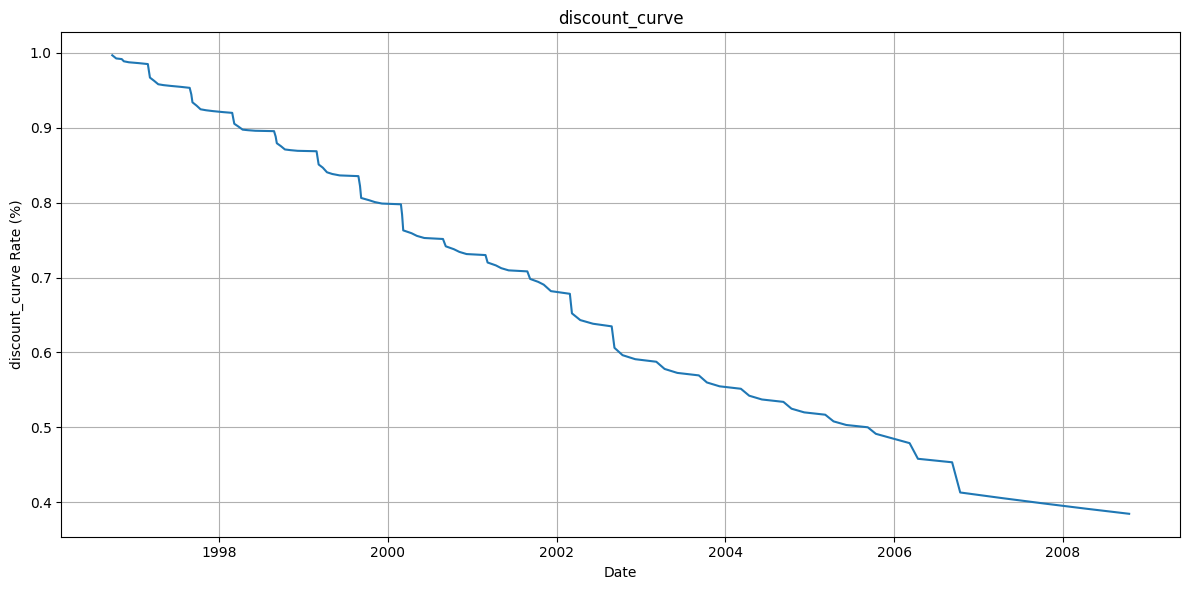

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(bond_cash_flow_date, d, label="discount_curve")
plt.title("discount_curve")
plt.xlabel("Date")
plt.ylabel("discount_curve Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### References

- Filipovic, D. (2009). *Term-Structure Models: A Graduate Course*. Springer Finance Textbooks. Springer Science & Business Media. ISBN: 978-3540680154.
- https://www.coursera.org/learn/interest-rate-models/home/module/3
- 